In [1]:
import numpy as np
from glob import glob
from os.path import join
import sys
import sh
import os
import math
from slurmpy import Slurm
import mtspec as mft
from obspy import read
from obspy import UTCDateTime
import obspy.taup
import subprocess
import matplotlib.pyplot as plt
from operator import itemgetter
model = obspy.taup.TauPyModel(model='ak135')
%matplotlib inline

In [2]:
######## utils functions
def get_dirs(base,absolute=0):
    """
    basedir is the dep_pert_search dir
    default gives relative path to fit the things in mv_results
    """
    all_dirs = glob(join(base, "work", "*"))
    if(absolute==1):
        curdir = os.path.abspath(".")
        for idir in range(0,len(all_dirs)):
            all_dirs[idir] = join(curdir, all_dirs[idir])
    
    #all_dirs.remove("dep_pert_search/work/CMTSOLUTION_00")   # no need to calc '00', already calc'd
    return all_dirs   # right now in the test just use all the perturbations

def mv_results(basedir,cal_dirs):     
    """
    basedir is the dep_pert_search dir
    cal_dirs is the calculation dirs in the work dir, i.e., CMTSOLUTION_**
    """
    sh.mkdir("-p", join(basedir, "syn_data"))
    for idir in cal_dirs:
        print(idir)
        pert = idir.strip().split("/")[2]
        synnm = pert+"_"+evtnm
        sh.mkdir("-p", join(basedir, "syn_data", synnm))
        sh.cp(glob(join(idir,"OUTPUT_FILES", "*.sac")), # cannot use sh to cp *.sac, use glob instead
              join(basedir, "syn_data", synnm))
        
def proc_syn(nproc,N_each,N_total,parlist,evnm):
    """
    generate slurm submissions for synthetics pre-processing
    """
    result = ""
    curdir = os.path.abspath(".")
    # for pre_proc.py
    result += f"echo 'start pre_processing'; "
    result += f". /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; "
    result += f"conda activate python3; "
    iiter = 0
    for ieach in range(N_each):
        # if N_each-1
        if(ieach == N_each-1):
            inc = ieach*nproc
            per = parlist[ieach]
            result += f"ibrun -n {nproc} -o {inc} ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm={evnm} --basedir=dep_pert_search --period_max=80 --period_min=10; "
        else:
            inc = ieach*nproc
            per = parlist[ieach]
            result += f"ibrun -n {nproc} -o {inc} ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm={evnm} --basedir=dep_pert_search --period_max=80 --period_min=10 & "
        # cd
    result += f"wait; "
    result += f"echo 'end iteration {iiter}'; "
    print(result)
    s = Slurm("sync", {"nodes": math.ceil(N_each*nproc/48), "ntasks": N_each*nproc,
                       "partition": 'normal', "time": "02:00:00", "account": 'TG-EAR140030',
                      "mail-user": 'zhouton3@msu.edu', "mail-type": 'all'})
    s.run(result)
    
def proc_syn_all(nproc,n_each,par_dict):
    result = ""
    nevt = len(par_dict)
    evts = list(par_dict.keys())
    absdirlst = []
    pert_code_lst = []
    curdir = os.path.abspath(".")
    for ievt in range(0,nevt):
        evnm = evts[ievt]
        parlist = par_dict[evnm]
        # construct abs dirs for each par
        for ipar in parlist:
            absdirlst.append(join(curdir,"cmt3d_syn_"+evnm))
            pert_code_lst.append(ipar)

    # construct command
    # for pre_proc.py
    result += f"echo 'start pre_processing'; "
    result += f". /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; "
    result += f"conda activate python3; "
    ncal = len(absdirlst)
    n_iter = math.ceil(ncal/n_each)
    n_left = ncal - (n_iter - 1) * n_each
    for iiter in range(0,n_iter):
        if(iiter == n_iter - 1):
            nn = n_left
        else:
            nn = n_each
        for ieach in range(0,nn):
            i_proc = iiter*n_each + ieach
            inc = ieach*nproc
            per = pert_code_lst[i_proc]
            to_dir = absdirlst[i_proc]
            evnm = (to_dir.strip().split("/")[-1]).split("_")[-1]
            result += f"cd {to_dir}; "      # absolute directory
            # if the last one of this iteration
            if(ieach == nn-1):
                result += f"ibrun -n {nproc} -o {inc} ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm={evnm} --basedir=dep_pert_search --period_max=80 --period_min=10; "
            else:
                result += f"ibrun -n {nproc} -o {inc} ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm={evnm} --basedir=dep_pert_search --period_max=80 --period_min=10 & "
            # cd
        result += f"wait; "
        result += f"echo 'end iteration {iiter}'; "
    print(result)
    runtimes = "0"+str(n_iter)+":00:00"
    ############## skx-dev max runtime is 2, max cores is 4*48 = 192, max run is 384 [but very fast]
    ############## doing more than that use normal
    s = Slurm("sync", {"nodes": math.ceil(n_each*nproc/48), "ntasks": n_each*nproc,
                       "partition": 'skx-dev', "time": "02:00:00", "account": 'TG-EAR140030',
                      "mail-user": 'zhouton3@msu.edu', "mail-type": 'all'})
    s.run(result)
    
def read_cmt(file_cmt):
    cmtfile = open(file_cmt,'r')
    for icmt in cmtfile.readlines():
        cmtline = icmt.strip().split()
        if(cmtline[0] == "depth:"):
            dep = float(cmtline[1])
        elif(cmtline[0] == "latitude:"):
            lat = float(cmtline[-1])
        elif(cmtline[0] == "longitude:"):
            lon = float(cmtline[-1])
        elif(cmtline[0] == "Mrr:"):
            Mrr = float(cmtline[-1])
        elif(cmtline[0] == "Mtt:"):
            Mtt = float(cmtline[-1])
        elif(cmtline[0] == "Mpp:"):
            Mpp = float(cmtline[-1])
        elif(cmtline[0] == "Mrt:"):
            Mrt = float(cmtline[-1])
        elif(cmtline[0] == "Mrp:"):
            Mrp = float(cmtline[-1])
        elif(cmtline[0] == "Mtp:"):
            Mtp = float(cmtline[-1])
    return dep,lon,lat,Mrr,Mtt,Mpp,Mrt,Mrp,Mtp

def update_cmt(old_file_cmt,new_file_cmt,depth,lat=None,lon=None,MTS=None):
    """
    default only update depth (it is must), lat=None, lon=None, MTS (moment tensor
    list, [Mrr,Mtt,Mpp,Mrt,Mrp,Mtp]) = None
    """
    cmtfile = open(old_file_cmt,'r')
    newcmtfile = open(new_file_cmt,'w')
    for icmt in cmtfile.readlines():
        cmtline = icmt.strip().split()
        if(cmtline[0] == "depth:"):
            newcmtfile.writelines(cmtline[0]+"          "+str(depth)+"\n")
        elif(cmtline[0] == "latitude:"):
            if(lat!=None):
                newcmtfile.writelines(cmtline[0]+"        "+str(depth)+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "longitude:"):
            if(lat!=None):
                newcmtfile.writelines(cmtline[0]+"       "+str(depth)+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mrr:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[0])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mtt:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[1])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mpp:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[2])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mrt:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[3])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mrp:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[4])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mtp:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[5])+"\n")
            else:
                newcmtfile.writelines(icmt)
        else:
            newcmtfile.writelines(icmt)
    cmtfile.close()
    newcmtfile.close()
    return 0
    

In [ ]:
###### main functions 
import os
import numpy as np
import mtspec as mft
from obspy import read
from obspy import UTCDateTime
import obspy.taup
import subprocess
import matplotlib.pyplot as plt
model = obspy.taup.TauPyModel(model='ak135')

def cal_wf_similarity(obs1,syn1,wins,wine):
    """
    input: obspy stream, window start/end
    output: waveform similarity
    """
    obs = obs1.slice(wins,wine)
    syn = syn1.slice(wins,wine)
    tp_t = obs[0].data
    tp_r = obs[1].data
    tp_z = obs[2].data
    wi_t = syn[0].data
    wi_r = syn[1].data
    wi_z = syn[2].data
    CCT = np.sum(np.abs(tp_t * wi_t) + np.abs(tp_r * wi_r) + np.abs(tp_z * wi_z)) / np.sqrt(
        np.sum(tp_t * tp_t + tp_r * tp_r + tp_z * tp_z) *
        np.sum(wi_r * wi_r + wi_t * wi_t + wi_z * wi_z))
    return CCT

def fixedwin(base,stafile,evtnm,pmin,pmax):
    """
    generate fixed time window based on AK135 travel time
    base: base directory
    stafile: the station file, in the base dir
    evtnm: event name
    output file is set "fixedwin_out.txt" in the base dir
    also returns a window dict, key: stnm value: [gcarc, baz, windows ...]
    provided the directories of obs / syn data are in the syn_processed and obs_processed dirs
    """
    syndir = "syn_processed"
    obsdir = "obs_processed"
    fout = open(base+"/fixedwin_out.txt",'w')
    os.chdir(base)     # cd to the base dir
    filelist = glob(join(obsdir, "*"))
    nfile = len(filelist)
    results = {}
    #nsta = nfile / 3
    fout.writelines(str(nfile)+"\n")
    # loop over stations
    fsta = open(stafile,'r')
    for sta in fsta.readlines():
        staline = sta.strip().split()
        stnm = staline[0]
        netwk = staline[1]
        obs={'z':obsdir+"/"+netwk+"."+stnm+"..Z",
           'r':obsdir+"/"+netwk+"."+stnm+"..R",
           't':obsdir+"/"+netwk+"."+stnm+"..T"}
        syn={'z':syndir+"/"+netwk+"."+stnm+"..Z.00",
           'r':syndir+"/"+netwk+"."+stnm+"..R.00",
           't':syndir+"/"+netwk+"."+stnm+"..T.00"}   # use "00" to select windows that wf similarity larger than 0.5
        # read obs and syn
        for ichnl in ['t','r','z']:
            if(ichnl=='t'):
                obs_st = read(obs[ichnl])
                syn_st = read(syn[ichnl])
            else:
                obs_st += read(obs[ichnl])
                syn_st += read(syn[ichnl])
        starttime = obs_st[0].stats.starttime
        # assume data after pre_proc_data.py, no need to filter / resample
        obs_st.filter("bandpass",freqmin=float(1/pmax),freqmax=float(1/pmin))
        syn_st.filter("bandpass",freqmin=float(1/pmax),freqmax=float(1/pmin))
        # define null value
        ptime=-12345
        stime=-12345
        surftime=-12345
        cmd = 'saclst gcarc evdp az npts delta f {}'.format(obs['z']).split()
        gcarc, evdp, az, npts, delta = subprocess.check_output(cmd).decode().split()[1:]
        gcarc = float(gcarc)
        evdp = float(evdp)
        az = float(az)
        npts = int(npts) - 1
        delta = float(delta)
        tracetime = npts * delta       # the trace recorded time
        label_close = 0
        print("gcarc is %f evdp is %f" %(gcarc,evdp))
        arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["P"])
        if(len(arrivals)!=0):
            ptime = arrivals[0].time
        else:
            arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["p"])
            if(len(arrivals)!=0):
                ptime = arrivals[0].time
                label_close = 1             ### this considers too close stations ###
               
        arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["S"])
        if(len(arrivals)!=0):
            stime = arrivals[0].time
        else:
            arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["s"])
            if(len(arrivals)!=0):
                stime = arrivals[0].time
                label_close = 1             ### this excludes too close stations ###
               
        arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["3.5kmps"])
        if(len(arrivals)!=0):
            surftime = arrivals[0].time
        
        # get p wave coda, such phases includes pP, multiple PPs. 
        # pP is too close to P if the eq is too shallow. we use PP
        # to select the max and min PP to determin whether to have multiple windows
        #arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["PP"])
        #if(len(arrivals)!=0):
        #    nPP=len(arrivals)
        #    PP1 = arrivals[0].time
        #    PPn = arrivals[nPP-1].time
        #else:
        #    PP1 = -12345
        #    PPn = -12345
        # abandon using PP window (3/22/19)
        #######################################################
        if(ptime==-12345 or stime==-12345 or surftime==-12345):
            print("travel time error: %s" %(obs['z'])) 
            results[stnm+netwk] = "NULL"
            print(stnm+netwk+",NULL")
            continue
        # some flags
        label_win = 0
        high_cc_win = 0
        # calc win
        if(gcarc<10):  # local stations, only use Pnl and Surface phases window
            
            if(label_close==1):
                win1s = 0
                win1e = stime + 60
                # check window elligibity
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                    
            else:     # pnl's window number is 1, id number is 1; surf's window number is 3, id number is 4
                if(ptime<20): # very very local station (within 100 km)
                    win1s = 0
                    win1e = stime
                    win3s = stime
                    win3e = stime + 60
                elif(ptime<60): # about 1 - 4 deg
                    win1s = ptime - 10
                    win1e = ptime + 30
                    win3s = stime - 10
                    win3e = stime + 110
                else:           # about > 4 deg
                    win1s = ptime - 20
                    win1e = ptime + 60
                    win3s = stime - 10
                    win3e = stime + 180
                # check window elligibity
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win3s,starttime+win3e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 4    ### local station 2nd win is surface
            ### end of local stations
        else:     # regional stations, s wave window number is 2, id number is 2
            win1s = ptime - 20
            win1e = ptime + 60
            win2s = stime - 20
            win2e = stime + 80
            win3s = surftime - 40
            win3e = surftime + 180
                
            # there might be some window exceeds the trace time. find them and remove
            if(win3s + 100 > tracetime):  # surf window is at least 100 s, otherwise remove the window
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win2s,starttime+win2e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 2

            elif(win3e > tracetime):            # cut to the end of the trace
                win3e = tracetime
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win2s,starttime+win2e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 2
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win3s,starttime+win3e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 4

            else:
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win2s,starttime+win2e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 2
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win3s,starttime+win3e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 4
        
        # skip stations with no eiligible windows
        if(high_cc_win==0 and label_win == 0):
            print("no windows for station: "+stnm+netwk)
            continue
        # get channel weighting ######## and output the file for cmt3d
        for comp in ['z','r','t']:
            fout.writelines(obs[comp]+"\n")
            fout.writelines(syn[comp]+"\n")
            # get weights for different time windows
            if(comp=='z'):
                if(gcarc<10):
                    wt_p = 1.15
                    wt_sf = 2   # most sensitive
                else:
                    wt_p = 1
                    wt_pp = 1.5
                    wt_s = 1
                    wt_sf = 1    # rayleigh wave
            elif(comp=='r'):
                if(gcarc<10):
                    wt_p = 1.15
                    wt_sf = 1.5
                else:
                    wt_p = 1
                    wt_pp = 1.5
                    wt_s = 1
                    wt_sf = 0.78
            else:
                if(gcarc<10):
                    wt_p = 0.5  # hard to see pnl in tangential comp
                    wt_sf = 1.5
                else:
                    wt_p = 0.5   # no p in tangential comp.
                    wt_pp = 0.1
                    wt_s = 1
                    wt_sf = 0.98  # love wave
            
            # output for cmt3d
            if(label_win==0):  # no windows eiligible
                continue
            elif(label_win==1 and label_close==1):   # very close station
                fout.writelines(str(1)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                print(stnm+netwk+",is a close station window is "+str(win1s)+" "+str(win1e))
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e]
            elif(high_cc_win==1):      #window 1
                fout.writelines(str(1)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e]
            elif(high_cc_win==2):      #window 2
                fout.writelines(str(1)+"\n")
                fout.writelines(str(win2s)+" "+str(win2e)+" 0 "+str(wt_s)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win2s, win2e]
            elif(high_cc_win==4):      #window 3
                fout.writelines(str(1)+"\n")
                fout.writelines(str(win3s)+" "+str(win3e)+" 0 "+str(wt_sf)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win3s, win3e]
            elif(high_cc_win==3):      #window 1,2
                fout.writelines(str(2)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                fout.writelines(str(win2s)+" "+str(win2e)+" 0 "+str(wt_s)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e, win2s, win2e]
            elif(high_cc_win==5):      #window 1,3
                fout.writelines(str(2)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                fout.writelines(str(win3s)+" "+str(win3e)+" 0 "+str(wt_sf)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e, win3s, win3e]
            elif(high_cc_win==6):      #window 2,3
                fout.writelines(str(2)+"\n")
                fout.writelines(str(win2s)+" "+str(win2e)+" 0 "+str(wt_s)+"\n")
                fout.writelines(str(win3s)+" "+str(win3e)+" 0 "+str(wt_sf)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win2s, win2e, win3s, win3e]
            elif(high_cc_win==7):      #window 1,2,3
                fout.writelines(str(3)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                fout.writelines(str(win2s)+" "+str(win2e)+" 0 "+str(wt_s)+"\n")
                fout.writelines(str(win3s)+" "+str(win3e)+" 0 "+str(wt_sf)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e, win2s, win2e, win3s, win3e]        
            
                

        print("adding %s to output file list" %(obs['z']))

    fout.close()
    fsta.close()
    os.chdir("../")     # cd outside
    return results

def cal_misfit(plot,obs,syn,mistype,dt=0,pmin=15,pmax=50):
    """
    dt is required if mistype = 'spec'. default is 0. if not given in 'spec' raise an error
    frequency range is optional, default is 0.02 to 0.067 Hz (Zhe et al., 2016) But my default is 0.02 to 0.1 Hz
    returns a scaler value of misfit
    """
    freqmin = float(1/pmax)
    freqmax = float(1/pmin)
    if(mistype=='misfit'):
        # perform CAP
        cor = np.correlate(syn,obs,mode='full')
        cs = int(np.where(cor==np.max(cor))[0][0])-int(len(obs))
        #print("time shift: "+str(0.1*cs))
        if(cs>0):
            obs_trim = obs[0:len(obs)-cs]
            syn_trim = syn[cs:]
        else:
            cs = np.abs(cs)
            obs_trim = obs[cs:]
            syn_trim = syn[0:len(syn)-cs]
        misfit = np.sqrt(np.sum((obs_trim-syn_trim)**2))

    elif(mistype=='spec'):
        # perform rayleigh wave multitaper spectrum measurement
        if(dt==0):
            raise Exception("dt not given")
        specobs,freq = mft.multitaper.mtspec(obs,dt,time_bandwidth=3.5)  # returns power spectrum
        specsyn,freq = mft.multitaper.mtspec(syn,dt,time_bandwidth=3.5)
        freqs = np.where(freq>=freqmin)[0][0]
        freqe = np.where(freq>freqmax)[0][0] - 1
        specobs = specobs[freqs:freqe]
        specsyn = specsyn[freqs:freqe]
        misfit = np.sum(np.abs(np.log10(specobs / specsyn))/len(specobs))   # absolute value
        
    if(plot!=0 and plot!='0'):
        # output figures
        pinfo = plot.strip().split(",")
        if(mistype=='misfit'):
            plt.figure()
            plt.plot(0.1*np.arange(0,len(obs_trim)),obs_trim,color='black')
            plt.plot(0.1*np.arange(0,len(syn_trim)),syn_trim,color='red',alpha=0.6)
            plt.title("CAP misfit "+str(misfit)+"time shift: "+str(0.1*cs)+" "+pinfo[1]+" "+pinfo[0]+" win #"+pinfo[2]+" pert "+pinfo[3])
        elif(mistype=='spec'):
            plt.figure()
            plt.plot(freq[freqs:freqe],specobs,color='black')
            plt.plot(freq[freqs:freqe],specsyn,color='red',alpha=0.6)
            plt.title("Rayleigh spectrum misfit: "+str(misfit)+" "+pinfo[1]+" "+pinfo[0]+" win #"+pinfo[2]+" pert "+pinfo[3])
    
    return misfit

def misfit_f(evnm,base,stations,windows,parlist,pmin,pmax,spatial_weighting=0,surf_spec=1):
    """
    calculate misfit based on stations obs syn windows and weighting
    evnm: event name
    base: base directory
    stations: stations file, in the base directory
    windows: window dictionary
    parlist: depth perturb parameter list
    spatial weighting: 0-epicentral-distance and azimuthal weighting(default); 1-epicentral distance weighting only; 2-azimuthal distance weighting only
    surf_spec: 0- no (only apply the waveform misfit); 1- yes (default, apply the surface wave spectra misfit)
    returns: the weighting function
    provided the directories of obs / syn data are in the syn_processed and obs_processed dirs
    """
    ####### need to exclude some stations with very low waveform similarity (i.e., less than 0.5)
    syndir = "syn_processed"
    obsdir = "obs_processed"
    os.chdir(base)    # cd to base dir
    nsta = len(open(stations,'r').readlines())
    #nsta = len(windows)

    npar = len(parlist)
    # define reference epicentral distance and default azimuth bin
    r_ref = 1       # zhe's paper didn't give one
    azi_bin = 15    # in degree
    # array to store station misfit
    print(npar)
    print(nsta)
    Ec = np.zeros((npar,nsta))   # store the misfit for each station separately 
    Es = np.zeros((npar,nsta))   # store the spectro for each station separately
    print(np.shape(Ec))
    all_az = np.zeros((nsta))       # store the back azimuth for the weighting
    print(np.shape(all_az))
    # also have the azimuthal weighting, not implemented yet
    ista = 0
    
    # loop over stations, order: STATION file order
    fsta = open(stations,'r')
    for sta in fsta.readlines():
        staline = sta.strip().split()
        stnm = staline[0]
        netwk = staline[1]
        if(stnm+netwk not in windows.keys()):
            continue
        if(windows[stnm+netwk]=="NULL"):
            continue
            # exclude travel time error stations
        obs={'t':obsdir+"/"+netwk+"."+stnm+"..T",
           'r':obsdir+"/"+netwk+"."+stnm+"..R",
           'z':obsdir+"/"+netwk+"."+stnm+"..Z"}
        
        # read the obs waveform
        for ichnl in ['t','r','z']:
            if(ichnl=='t'):
                obs_st = read(obs[ichnl])
            else:
                obs_st += read(obs[ichnl])
        otime = obs_st[0].stats.starttime + obs_st[0].stats.sac.o
        
        # just let here to check whether there's NaNs in the obs or syn. only used to proceed the work (3/22/19)
        # next time the SNR check should be added another criteria to exclude some components has no data or ?NaN data
        if(np.isnan(obs_st[0].data + obs_st[1].data + obs_st[2].data).any()):
            print("problem: this station {} has no data or 'nan' data".format(stnm+netwk))
            continue
        
        if(ista==0):
            print(obs_st)
            print(otime)
        
        
        # get windows and weighting
        winlist = windows[stnm+netwk]
        gcarc = winlist[0]
        all_az[ista] = winlist[1]
        nwin = int(len(winlist) / 2) - 1
        
        # filtering
        obs_st.filter("bandpass",freqmin=float(1/pmax),freqmax=float(1/pmin))
        
        # loop over the depth perturb parameters
        for ipar in range(0,len(parlist)):
            syn={'t':syndir+"/"+netwk+"."+stnm+"..T."+parlist[ipar],
               'r':syndir+"/"+netwk+"."+stnm+"..R."+parlist[ipar],
               'z':syndir+"/"+netwk+"."+stnm+"..Z."+parlist[ipar]}
            
            # read the syn waveform
            chn = ['t','r','z']
            for ichnl in range(0,3):
                if(chn[ichnl]=='t'):
                    syn_st = read(syn[chn[ichnl]])
                else:
                    syn_st += read(syn[chn[ichnl]])
                    
            #filtering
            syn_st.filter("bandpass",freqmin=float(1/pmax),freqmax=float(1/pmin))
            
            # cut windows and calculate misfits
            if(nwin==2):              # local stations
                for iwin in range(0,nwin):
                    obs_st1 = obs_st.slice(otime+winlist[2+iwin*2],otime+winlist[3+iwin*2])
                    syn_st1 = syn_st.slice(otime+winlist[2+iwin*2],otime+winlist[3+iwin*2])
                    if(iwin==0):    # Pnl phase 
                        chwt = {'t':0.5,'r':1.15,'z':1.15}
                        diswt = gcarc / r_ref
                    else:           # surface phase 
                        chwt = {'t':1.5,'r':1.5,'z':2}
                        diswt = np.sqrt(gcarc / r_ref)
                    
                    # loop over the channels
                    if(len(obs_st1)!=3):
                        print(stnm+netwk+" have bug!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    for ichn in range(0,3):          
                        obs1 = obs_st1[ichn].data
                        syn1 = syn_st1[ichn].data
                        if(ista%200==0 and nwin==4):
                            plot = chn[ichn]+","+stnm+","+str(iwin)+","+parlist[ipar]
                        else:
                            plot = 0
                        Ec[ipar,ista] += cal_misfit(plot,obs1,syn1,'misfit') * chwt[chn[ichn]] * diswt
                        
                        if(iwin==1 and ichn==2):   # Rayleigh wave spectrum misfit
                            dt = obs_st[ichn].stats.sac.delta
                            Es[ipar,ista] = cal_misfit(plot,obs1,syn1,'spec',dt) 
                        else:
                            Es[ipar,ista] = 0
                            
            else:                  # regional stations
                for iwin in range(0,nwin):
                    obs_st1 = obs_st.slice(otime+winlist[2+iwin*2],otime+winlist[3+iwin*2])
                    syn_st1 = syn_st.slice(otime+winlist[2+iwin*2],otime+winlist[3+iwin*2])
                    if(iwin==0):             # P phase 
                        chwt = {'t':0.5,'r':1,'z':1}
                        diswt = gcarc / r_ref
                    elif(iwin==1):           # PP phase 
                        chwt = {'t':0.5,'r':1.5,'z':1.5}
                        diswt = gcarc / r_ref
                    elif(iwin==2):          # S phase
                        chwt = {'t':1,'r':1,'z':1}
                        diswt = gcarc / r_ref
                    else:                   # surface wave
                        chwt = {'t':0.98,'r':0.78,'z':1}
                        diswt = np.sqrt(gcarc / r_ref)
                    # loop over the channels
                    if(len(obs_st1)!=3):
                        print(stnm+netwk+" have bug!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    for ichn in range(0,3):          
                        obs1 = obs_st1[ichn].data
                        syn1 = syn_st1[ichn].data
                        if(ista%200==0 and nwin==4):
                            plot = chn[ichn]+","+stnm+","+str(iwin)+","+parlist[ipar]
                        else:
                            plot = 0
                        Ec[ipar,ista] += cal_misfit(plot,obs1,syn1,'misfit') * chwt[chn[ichn]] * diswt
                            
                        if(iwin==3 and ichn==2): # Rayleigh wave spectrum misfit
                            dt = obs_st[ichn].stats.sac.delta
                            Es[ipar,ista] = cal_misfit(plot,obs1,syn1,'spec',dt) 
                        else:
                            Es[ipar,ista] = 0
            # finish loop over parameters
        
        ista += 1   
        # finish loop over stations
        
    os.chdir("../") 
    
    Ecall = 0
    Esall = 0

    # combine all the misfits together and apply the azimuth weighting
    n_bin = int(360 / azi_bin)
    nazplot=[]
    Ecbinplot=[]
    Esbinplot=[]
    for ibin in range(0,n_bin):
        azi_s = azi_bin * ibin
        azi_e = azi_bin * (ibin + 1)
        all_az[all_az<0] = all_az[all_az<0] + 360
        
        azidx = np.where((all_az>=azi_s) & (all_az < azi_e))    # logical array must be like this
        naz = np.size(azidx)   # azidx is a np.array object, (1*n) do not use len!
        azidx = np.squeeze(azidx)   # also squeeze this array to use later
        if(naz!=0):
            aziweight = 1 / naz   # azimuth weight according to the density in the bin
        else:
            aziweight = 0     # there may be no station in a bin, put weight = 0
        print(aziweight)
        print(azidx)
        # calculate the combined misfit function
        # extract the stations within the bin
        if(azidx!=[]):
            Ec_bin = np.sum(Ec[:,azidx],axis=1) 
            Es_bin = np.sum(Es[:,azidx],axis=1) 
        else:
            Ec_bin = 0
            Es_bin = 0
        
        Ecall += Ec_bin * aziweight
        Esall += Es_bin * aziweight
        
        nazplot.append(naz)
        Ecbinplot.append(str(Ec_bin))
        Esbinplot.append(str(Es_bin))
        
    # normalize and get the total misfit (use zhe's equation 5)
    Ecnorm = Ecall / (np.amax(Ecall)-np.amin(Ecall))
    Esnorm = Esall / (np.amax(Esall)-np.amin(Esall))
    
    print("Ec:"+str(Ecall))
    print("Es:"+str(Esall))
    
    return Ecall,Esall,nazplot,Ecbinplot,Esbinplot



In [19]:
#######3 next time change the code to submit multiple obs pre-procs into one job
event_list_file = "evtlst.txt"
basedir = "/work/05880/tg851792/stampede2/WUS/CMT_inversion_test"
model_dir = '/work/05880/tg851792/stampede2/WUS/new_region_us2016hybrid'
pmin = 10    # min period used
pmax = 80    # max period used
cal_dirs = []

for ievt in open(event_list_file,'r').readlines():
    evtnm = ievt.strip()
    
    os.chdir("cmt3d_syn_"+evtnm)
    curdir = os.path.abspath(".")   # event main dir
    
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    
    #### gather results ####
    mv_results("dep_pert_search",cal_dirs)
    
    #### pre-proc obs waveform data ####
    sh.cp(join(basedir, "pre_proc_data.py"), curdir)
    sh.cp(join(curdir, "dep_pert_search", "work", "CMTSOLUTION_00", "DATA", "CMTSOLUTION"), "./")
    sh.cp(join(curdir, "dep_pert_search", "work", "CMTSOLUTION_00", "OUTPUT_FILES", "STATIONS_FILTERED"), 
          join(".", "STATIONS"))
    if(not os.path.exists(join(curdir,"dep_pert_search",evtnm))):
        sh.ln("-s",join(curdir,evtnm),join(curdir,"dep_pert_search",evtnm))
    # gen script for slurm
    per = "obs"
    comm = f"echo 'start pre_processing obs'; "
    comm += f". /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; "
    comm += f"conda activate python3; "
    comm += f"ibrun ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm={evtnm} --basedir=dep_pert_search --period_max={pmax} --period_min={pmin}; "
    comm += f"wait; "
    comm += f"echo 'end pre_processing obs'; "
    print(comm)
    # submit to the slurm queue
    s = Slurm("sync", {"nodes": "1", "ntasks": "1",
                       "partition": 'normal', "time": "02:00:00", "account": 'TG-EAR140030',
                      "mail-user": 'zhouton3@msu.edu', "mail-type": 'all'})
    s.run(comm)
    os.chdir('..')


dep_pert_search/work/CMTSOLUTION_d3
dep_pert_search/work/CMTSOLUTION_d12
dep_pert_search/work/CMTSOLUTION_u12
dep_pert_search/work/CMTSOLUTION_u15
dep_pert_search/work/CMTSOLUTION_u3
dep_pert_search/work/CMTSOLUTION_d9
dep_pert_search/work/CMTSOLUTION_00
dep_pert_search/work/CMTSOLUTION_u6
dep_pert_search/work/CMTSOLUTION_d6
dep_pert_search/work/CMTSOLUTION_u9
echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=201501282109A --basedir=dep_pert_search --period_max=80 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login1)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3251121'


In [20]:
##### pre-proc the synthetics
event_list_file = "evtlst.txt"
basedir = "/work/05880/tg851792/stampede2/WUS/CMT_inversion_test"
model_dir = '/work/05880/tg851792/stampede2/WUS/new_region_us2016hybrid'
pmin = 10    # min period used
pmax = 80    # max period used
cal_dirs = []
pert_dict_all = {}
for ievt in open(event_list_file,'r').readlines():
    evtnm = ievt.strip()
    
    os.chdir("cmt3d_syn_"+evtnm)
    curdir = os.path.abspath(".")   # event main dir
    
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    pert_list = []
    for idir in cal_dirs:
        ipert = idir.strip().split("/")[2]
        pert_list.append(ipert.strip().split("_")[1])
    print(pert_list)
    pert_dict_all[evtnm] = pert_list
    nevt = len(pert_dict_all)
    print(nevt)
    
    sh.cp(join("dep_pert_search/stations_used.txt"),"./")
    
    os.chdir("..")
n_cal = 0
for idct in pert_dict_all.keys():
    n_cal += len(pert_dict_all[idct])
print(n_cal)
nproc = 1
n_each = n_cal
proc_syn_all(nproc,n_each,pert_dict_all)


['d3', 'd12', 'u12', 'u15', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
1
10
echo 'start pre_processing'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; cd /work/05880/tg851792/stampede2/WUS/CMT_inversion_test/cmt3d_syn_201501282109A; ibrun -n 1 -o 0 ./pre_proc_data.py --pert_type=0 --pert_code=d3 --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm=201501282109A --basedir=dep_pert_search --period_max=80 --period_min=10 & cd /work/05880/tg851792/stampede2/WUS/CMT_inversion_test/cmt3d_syn_201501282109A; ibrun -n 1 -o 1 ./pre_proc_data.py --pert_type=0 --pert_code=d12 --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm=201501282109A --basedir=dep_pert_search --period_max=80 --period_min=10 & cd /work/05880/tg851792/stampede2/WUS/CMT_inversion_test/cmt3d_syn_201501282109A; ibrun -n 1 -o 2 ./pre_proc_data.py --pert_type=0 --pert_code=u12 --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm=201501282109A --basedir=dep_pert_sear

submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login1)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (skx-dev)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3251572'


In [ ]:
##### main program
event_list_file = "evtlst.txt"
basedir = "/work/05880/tg851792/stampede2/WUS/CMT_inversion_test"
model_dir = '/work/05880/tg851792/stampede2/WUS/new_region_us2016hybrid'
pmin = 20    # min period used
pmax = 80    # max period used
pert_dict_all = {}
win_all = {}
Eca_all = {}
Esa_all = {}
naz_all = {}
depth_all = {}
Ecbin_all = {}
Esbin_all = {}
misfit_all = {}
manual_check = []
for ievt in open(event_list_file,'r').readlines():
    evtnm = ievt.strip()
    
    os.chdir("cmt3d_syn_"+evtnm)
    curdir = os.path.abspath(".")   # event main dir
    
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    pert_list = []
    for idir in cal_dirs:
        ipert = idir.strip().split("/")[2]
        pert_list.append(ipert.strip().split("_")[1])
    print(pert_list)
    pert_dict_all[evtnm] = pert_list
    nevt = len(pert_dict_all)
    print(nevt)

    base_dir_evt = "dep_pert_search"
    stations = "stations_used.txt"

    parlist = pert_list
    evdp,_,_,_,_,_,_,_,_ = read_cmt("CMTSOLUTION")
    depth = np.zeros((len(pert_list)))
    #print(depth)
    for i in range(0,len(pert_list)):
        pert_sign = pert_list[i].strip()[0]
        pert_val = pert_list[i].strip()[1:]
        if(pert_sign=='d'):
            depth[i] = evdp + int(pert_val)
        elif(pert_sign=='u'):
            depth[i] = evdp - int(pert_val)
        else:
            depth[i] = evdp

    result = dict(zip(depth,parlist))
    depth = sorted(result.keys())
    parlist = itemgetter(*depth)(result)
    depth = list(depth)
    parlist = list(parlist)
    print(depth)
    print(parlist)

    win = fixedwin(base_dir_evt,stations,evtnm,pmin,pmax)     # this two steps must be run separately because fixedwin calls sac which is slower than python script, may cause bugs
    Eca,Esa,naz,Ecbin,Esbin = misfit_f(evtnm,base_dir_evt,stations,win,parlist,pmin,pmax)
    Ecnorm = Eca / (np.amax(Eca)-np.amin(Eca))
    Esnorm = Esa / (np.amax(Esa)-np.amin(Esa))
    misfit = Ecnorm + Esnorm
    win_all[evtnm] = win
    Eca_all[evtnm] = Eca
    Esa_all[evtnm] = Esa
    naz_all[evtnm] = naz
    depth_all[evtnm] = depth
    Ecbin_all[evtnm] = Ecbin
    Esbin_all[evtnm] = Esbin
    misfit_all[evtnm] = misfit
    
    # find the min misfit and write down the new CMTSOLUTION file
    misidx = np.where(misfit==np.amin(misfit))[0][0]
    dep_new = depth[misidx]
    # if happens to be the boundary value
    if(misidx==0 or misidx==len(misfit)-1):
        manual_check.append(evtnm)
        dep_new = evdp  ### this case do not update the new depth because there may be problem.
    update_cmt("CMTSOLUTION","CMTSOLUTION_NEW",dep_new)
    
    
    os.chdir("..")
    
%store win_all
%store Eca_all
%store Esa_all
%store depth_all
%store Ecbin_all
%store Esbin_all
%store misfit_all
%store manual_check

['d3', 'd12', 'u12', 'u15', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
1
[15.0, 18.0, 21.0, 24.0, 27.0, 30.0, 33.0, 36.0, 39.0, 42.0]
['u15', 'u12', 'u9', 'u6', 'u3', '00', 'd3', 'd6', 'd9', 'd12']
gcarc is 10.529000 evdp is 30.000000
adding obs_processed/2G.IUGFS..Z to output file list
gcarc is 0.375152 evdp is 30.000000
FS02D7D,is a close station window is 0 74.2881353394
FS02D7D,is a close station window is 0 74.2881353394
FS02D7D,is a close station window is 0 74.2881353394
adding obs_processed/7D.FS02D..Z to output file list
gcarc is 0.159893 evdp is 30.000000
no windows for station: FS04D7D
gcarc is 0.384360 evdp is 30.000000
FS06D7D,is a close station window is 0 74.518155976
FS06D7D,is a close station window is 0 74.518155976
FS06D7D,is a close station window is 0 74.518155976
adding obs_processed/7D.FS06D..Z to output file list
gcarc is 0.267287 evdp is 30.000000
FS07D7D,is a close station window is 0 71.7634748338
FS07D7D,is a close station window is 0 71.7634748338
FS07D7D,is a clo

adding obs_processed/BK.TRAM..Z to output file list
gcarc is 5.695460 evdp is 30.000000
adding obs_processed/BK.TSCN..Z to output file list
gcarc is 2.910620 evdp is 30.000000
adding obs_processed/BK.VAK..Z to output file list
gcarc is 1.376590 evdp is 30.000000
adding obs_processed/BK.WDC..Z to output file list
gcarc is 3.341110 evdp is 30.000000
adding obs_processed/BK.WENL..Z to output file list
gcarc is 1.866280 evdp is 30.000000
adding obs_processed/BK.YBH..Z to output file list
gcarc is 4.135050 evdp is 30.000000
adding obs_processed/CC.ASBU..Z to output file list
gcarc is 4.167050 evdp is 30.000000
adding obs_processed/CC.CIHL..Z to output file list
gcarc is 4.108050 evdp is 30.000000
adding obs_processed/CC.CPCO..Z to output file list
gcarc is 6.154530 evdp is 30.000000
adding obs_processed/CC.JRO..Z to output file list
gcarc is 6.831130 evdp is 30.000000
adding obs_processed/CC.OBSR..Z to output file list
gcarc is 6.826460 evdp is 30.000000
adding obs_processed/CC.PANH..Z to o

gcarc is 7.112570 evdp is 30.000000
adding obs_processed/CI.LDR..Z to output file list
gcarc is 7.577300 evdp is 30.000000
adding obs_processed/CI.LFP..Z to output file list
gcarc is 8.008850 evdp is 30.000000
adding obs_processed/CI.LGB..Z to output file list
gcarc is 6.987920 evdp is 30.000000
adding obs_processed/CI.LJR..Z to output file list
gcarc is 9.298830 evdp is 30.000000
adding obs_processed/CI.LKH..Z to output file list
gcarc is 8.344430 evdp is 30.000000
adding obs_processed/CI.LLS..Z to output file list
gcarc is 7.503860 evdp is 30.000000
adding obs_processed/CI.LMR2..Z to output file list
gcarc is 8.488340 evdp is 30.000000
adding obs_processed/CI.LMS..Z to output file list
gcarc is 6.934310 evdp is 30.000000
adding obs_processed/CI.LMY..Z to output file list
gcarc is 6.393970 evdp is 30.000000
adding obs_processed/CI.LOC..Z to output file list
gcarc is 8.050380 evdp is 30.000000
adding obs_processed/CI.LPC..Z to output file list
gcarc is 7.119900 evdp is 30.000000
adding

gcarc is 6.842440 evdp is 30.000000
adding obs_processed/CI.TEH..Z to output file list
gcarc is 5.760760 evdp is 30.000000
adding obs_processed/CI.TIN..Z to output file list
gcarc is 9.326320 evdp is 30.000000
no windows for station: TORCI
gcarc is 6.844020 evdp is 30.000000
adding obs_processed/CI.TOW2..Z to output file list
gcarc is 7.257630 evdp is 30.000000
adding obs_processed/CI.TPO..Z to output file list
gcarc is 8.222950 evdp is 30.000000
adding obs_processed/CI.TUQ..Z to output file list
gcarc is 7.906590 evdp is 30.000000
adding obs_processed/CI.USC..Z to output file list
gcarc is 7.620930 evdp is 30.000000
adding obs_processed/CI.VCS..Z to output file list
gcarc is 5.555810 evdp is 30.000000
adding obs_processed/CI.VOG..Z to output file list
gcarc is 7.982900 evdp is 30.000000
adding obs_processed/CI.VTV..Z to output file list
gcarc is 6.437390 evdp is 30.000000
adding obs_processed/CI.WAS2..Z to output file list
gcarc is 6.816740 evdp is 30.000000
adding obs_processed/CI.WB

gcarc is 12.476000 evdp is 30.000000
adding obs_processed/TA.214A..Z to output file list
gcarc is 23.656900 evdp is 30.000000
adding obs_processed/TA.435B..Z to output file list
gcarc is 23.715200 evdp is 30.000000
adding obs_processed/TA.833A..Z to output file list
gcarc is 8.486320 evdp is 30.000000
adding obs_processed/TA.A04D..Z to output file list
gcarc is 21.224800 evdp is 30.000000
adding obs_processed/TA.ABTX..Z to output file list
gcarc is 8.109030 evdp is 30.000000
adding obs_processed/TA.B05D..Z to output file list
gcarc is 19.797400 evdp is 30.000000
adding obs_processed/TA.BGNE..Z to output file list
gcarc is 7.996710 evdp is 30.000000
adding obs_processed/TA.C06D..Z to output file list
gcarc is 7.276100 evdp is 30.000000
adding obs_processed/TA.D03D..Z to output file list
gcarc is 6.955970 evdp is 30.000000
adding obs_processed/TA.D04E..Z to output file list
gcarc is 6.371450 evdp is 30.000000
adding obs_processed/TA.E04D..Z to output file list
gcarc is 5.847790 evdp is 3

gcarc is 8.799080 evdp is 30.000000
adding obs_processed/UW.OMAK..Z to output file list
gcarc is 6.120650 evdp is 30.000000
adding obs_processed/UW.RADR..Z to output file list
gcarc is 7.339850 evdp is 30.000000
adding obs_processed/UW.RATT..Z to output file list
gcarc is 8.745110 evdp is 30.000000
no windows for station: SHUKUW
gcarc is 7.394970 evdp is 30.000000
adding obs_processed/UW.SP2..Z to output file list
gcarc is 7.619900 evdp is 30.000000
adding obs_processed/UW.TOLT..Z to output file list
gcarc is 6.815940 evdp is 30.000000
adding obs_processed/UW.WISH..Z to output file list
gcarc is 6.258230 evdp is 30.000000
adding obs_processed/XD.MH09..Z to output file list
gcarc is 9.181710 evdp is 30.000000
adding obs_processed/YN.TFRD..Z to output file list
gcarc is 4.173370 evdp is 30.000000
no windows for station: BB840Z5
gcarc is 5.045030 evdp is 30.000000
adding obs_processed/Z5.BB850..Z to output file list
gcarc is 5.695450 evdp is 30.000000
no windows for station: BB870Z5
gcarc

gcarc is 27.261800 evdp is 30.000000
adding obs_processed/N4.S44A..Z to output file list
gcarc is 31.572600 evdp is 30.000000
adding obs_processed/N4.S51A..Z to output file list
gcarc is 26.055100 evdp is 30.000000
adding obs_processed/N4.T42B..Z to output file list
gcarc is 27.925300 evdp is 30.000000
adding obs_processed/N4.T45B..Z to output file list
gcarc is 29.106900 evdp is 30.000000
adding obs_processed/N4.T47A..Z to output file list
gcarc is 30.820400 evdp is 30.000000
adding obs_processed/N4.T50A..Z to output file list
gcarc is 23.720400 evdp is 30.000000
adding obs_processed/N4.U38B..Z to output file list
gcarc is 30.267500 evdp is 30.000000
adding obs_processed/N4.U49A..Z to output file list
gcarc is 29.732000 evdp is 30.000000
adding obs_processed/N4.V48A..Z to output file list
gcarc is 31.594700 evdp is 30.000000
adding obs_processed/N4.V51A..Z to output file list
gcarc is 32.156600 evdp is 30.000000
adding obs_processed/N4.V52A..Z to output file list
gcarc is 32.813600 ev

gcarc is 29.937000 evdp is 30.000000
adding obs_processed/XO.KG41..Z to output file list
gcarc is 28.278600 evdp is 30.000000
adding obs_processed/XO.KH26..Z to output file list
gcarc is 28.498200 evdp is 30.000000
adding obs_processed/XO.KH28..Z to output file list
gcarc is 28.688000 evdp is 30.000000
adding obs_processed/XO.KH30..Z to output file list
gcarc is 28.845000 evdp is 30.000000
adding obs_processed/XO.KH32..Z to output file list
gcarc is 29.095300 evdp is 30.000000
adding obs_processed/XO.KH34..Z to output file list
gcarc is 29.334200 evdp is 30.000000
adding obs_processed/XO.KH36..Z to output file list
gcarc is 29.592400 evdp is 30.000000
adding obs_processed/XO.KH38..Z to output file list
gcarc is 30.003100 evdp is 30.000000
adding obs_processed/XO.KH42..Z to output file list
gcarc is 30.196900 evdp is 30.000000
adding obs_processed/XO.KH44..Z to output file list
gcarc is 30.562300 evdp is 30.000000
adding obs_processed/XO.KH48..Z to output file list
gcarc is 30.769500 ev

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:543: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:543: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


adding obs_processed/7D.FS04D..Z to output file list
gcarc is 19.679700 evdp is 14.900000
adding obs_processed/7D.FS08D..Z to output file list
gcarc is 20.112200 evdp is 14.900000
no windows for station: FS44D7D
gcarc is 20.585600 evdp is 14.900000
adding obs_processed/7D.G10D..Z to output file list
gcarc is 20.824900 evdp is 14.900000
adding obs_processed/7D.M16D..Z to output file list
gcarc is 10.431400 evdp is 14.900000
adding obs_processed/AZ.BZN..Z to output file list
gcarc is 10.212100 evdp is 14.900000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 10.525600 evdp is 14.900000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 10.400300 evdp is 14.900000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 10.629000 evdp is 14.900000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 10.267300 evdp is 14.900000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 9.837660 evdp is 14.900000
adding obs_processed/AZ.MONP2..Z to output fi

gcarc is 11.799500 evdp is 14.900000
adding obs_processed/CI.CHF..Z to output file list
gcarc is 11.359700 evdp is 14.900000
adding obs_processed/CI.CHN..Z to output file list
gcarc is 11.343000 evdp is 14.900000
adding obs_processed/CI.CIA..Z to output file list
gcarc is 11.432300 evdp is 14.900000
adding obs_processed/CI.CJM..Z to output file list
gcarc is 12.011800 evdp is 14.900000
adding obs_processed/CI.CJV2..Z to output file list
gcarc is 12.748200 evdp is 14.900000
adding obs_processed/CI.CLC..Z to output file list
gcarc is 11.237900 evdp is 14.900000
adding obs_processed/CI.CLT..Z to output file list
gcarc is 9.161860 evdp is 14.900000
adding obs_processed/CI.COA..Z to output file list
gcarc is 13.411800 evdp is 14.900000
adding obs_processed/CI.CRG..Z to output file list
gcarc is 9.595870 evdp is 14.900000
adding obs_processed/CI.CRR..Z to output file list
gcarc is 10.223700 evdp is 14.900000
adding obs_processed/CI.CTC..Z to output file list
gcarc is 10.185700 evdp is 14.900

gcarc is 12.132500 evdp is 14.900000
adding obs_processed/CI.OAT..Z to output file list
gcarc is 11.453000 evdp is 14.900000
adding obs_processed/CI.OLI..Z to output file list
gcarc is 9.905910 evdp is 14.900000
adding obs_processed/CI.OLP..Z to output file list
gcarc is 12.392200 evdp is 14.900000
adding obs_processed/CI.OSI..Z to output file list
gcarc is 10.546000 evdp is 14.900000
adding obs_processed/CI.PALA..Z to output file list
gcarc is 11.765800 evdp is 14.900000
adding obs_processed/CI.PASC..Z to output file list
gcarc is 12.186500 evdp is 14.900000
adding obs_processed/CI.PDE..Z to output file list
gcarc is 10.016800 evdp is 14.900000
adding obs_processed/CI.PDM..Z to output file list
gcarc is 11.755000 evdp is 14.900000
adding obs_processed/CI.PDR..Z to output file list
gcarc is 11.429300 evdp is 14.900000
adding obs_processed/CI.PDU..Z to output file list
gcarc is 11.000700 evdp is 14.900000
adding obs_processed/CI.PER..Z to output file list
gcarc is 14.001600 evdp is 14.9

adding obs_processed/IM.NV31..Z to output file list
gcarc is 17.632900 evdp is 14.900000
adding obs_processed/IM.PD31..Z to output file list
gcarc is 6.715830 evdp is 14.900000
adding obs_processed/IM.TX31..Z to output file list
gcarc is 6.715650 evdp is 14.900000
adding obs_processed/IM.TX32..Z to output file list
gcarc is 10.176300 evdp is 14.900000
adding obs_processed/IU.ANMO..Z to output file list
gcarc is 22.437700 evdp is 14.900000
adding obs_processed/IU.COR..Z to output file list
gcarc is 13.079900 evdp is 14.900000
adding obs_processed/IU.HKT..Z to output file list
gcarc is 19.507800 evdp is 14.900000
adding obs_processed/IU.RSSD..Z to output file list
gcarc is 1.448120 evdp is 14.900000
adding obs_processed/IU.SLBS..Z to output file list
gcarc is 7.277420 evdp is 14.900000
adding obs_processed/IU.TUC..Z to output file list
gcarc is 20.378700 evdp is 14.900000
adding obs_processed/IW.DLMT..Z to output file list
gcarc is 18.971900 evdp is 14.900000
adding obs_processed/IW.FLWY

gcarc is 17.690800 evdp is 14.900000
adding obs_processed/TA.K22A..Z to output file list
gcarc is 15.054900 evdp is 14.900000
adding obs_processed/TA.KSCO..Z to output file list
gcarc is 20.618200 evdp is 14.900000
adding obs_processed/TA.L02E..Z to output file list
gcarc is 20.081900 evdp is 14.900000
adding obs_processed/TA.L04D..Z to output file list
gcarc is 19.670500 evdp is 14.900000
adding obs_processed/TA.M02C..Z to output file list
gcarc is 19.526300 evdp is 14.900000
adding obs_processed/TA.M04C..Z to output file list
gcarc is 24.034700 evdp is 14.900000
adding obs_processed/TA.MDND..Z to output file list
gcarc is 10.622800 evdp is 14.900000
adding obs_processed/TA.MSTX..Z to output file list
gcarc is 19.273900 evdp is 14.900000
adding obs_processed/TA.N02D..Z to output file list
gcarc is 16.043200 evdp is 14.900000
adding obs_processed/TA.N23A..Z to output file list
gcarc is 18.700600 evdp is 14.900000
adding obs_processed/TA.O02D..Z to output file list
gcarc is 18.315400 ev

gcarc is 22.966300 evdp is 14.900000
adding obs_processed/N4.152A..Z to output file list
gcarc is 24.285400 evdp is 14.900000
adding obs_processed/N4.154A..Z to output file list
gcarc is 21.535200 evdp is 14.900000
adding obs_processed/N4.250A..Z to output file list
gcarc is 24.690700 evdp is 14.900000
adding obs_processed/N4.255A..Z to output file list
gcarc is 25.916400 evdp is 14.900000
adding obs_processed/N4.257A..Z to output file list
gcarc is 16.396700 evdp is 14.900000
adding obs_processed/N4.342B..Z to output file list
gcarc is 17.720700 evdp is 14.900000
adding obs_processed/N4.344B..Z to output file list
gcarc is 18.747700 evdp is 14.900000
adding obs_processed/N4.346B..Z to output file list
gcarc is 22.556000 evdp is 14.900000
adding obs_processed/N4.352A..Z to output file list
gcarc is 15.499800 evdp is 14.900000
adding obs_processed/N4.441B..Z to output file list
gcarc is 21.719800 evdp is 14.900000
adding obs_processed/N4.451A..Z to output file list
gcarc is 24.915200 ev

adding obs_processed/N4.Z38B..Z to output file list
gcarc is 20.386500 evdp is 14.900000
adding obs_processed/N4.Z47B..Z to output file list
gcarc is 22.748100 evdp is 14.900000
adding obs_processed/N4.Z51A..Z to output file list
gcarc is 23.928200 evdp is 14.900000
adding obs_processed/NM.BLO..Z to output file list
gcarc is 22.269200 evdp is 14.900000
adding obs_processed/NM.FFIL..Z to output file list
gcarc is 19.016700 evdp is 14.900000
adding obs_processed/NM.MGMO..Z to output file list
gcarc is 19.652400 evdp is 14.900000
adding obs_processed/NM.MPH..Z to output file list
gcarc is 22.644100 evdp is 14.900000
adding obs_processed/NM.OLIL..Z to output file list
gcarc is 20.063100 evdp is 14.900000
adding obs_processed/NM.PBMO..Z to output file list
gcarc is 20.990400 evdp is 14.900000
adding obs_processed/NM.PLAL..Z to output file list
gcarc is 20.399400 evdp is 14.900000
adding obs_processed/NM.PVMO..Z to output file list
gcarc is 21.369300 evdp is 14.900000
adding obs_processed/NM

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:543: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:543: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


adding obs_processed/AZ.BZN..Z to output file list
gcarc is 20.205200 evdp is 12.000000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 19.732500 evdp is 12.000000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 19.846000 evdp is 12.000000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 19.609400 evdp is 12.000000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 19.988900 evdp is 12.000000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 20.451400 evdp is 12.000000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 19.795800 evdp is 12.000000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 19.633600 evdp is 12.000000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 19.706300 evdp is 12.000000
adding obs_processed/AZ.SCI2..Z to output file list
gcarc is 19.669300 evdp is 12.000000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 19.791100 evdp is 12.000000
adding obs_processed/AZ.SND

gcarc is 17.412900 evdp is 12.000000
adding obs_processed/CI.CLC..Z to output file list
gcarc is 19.046600 evdp is 12.000000
adding obs_processed/CI.CLT..Z to output file list
gcarc is 20.975200 evdp is 12.000000
adding obs_processed/CI.COA..Z to output file list
gcarc is 17.168300 evdp is 12.000000
adding obs_processed/CI.CRG..Z to output file list
gcarc is 20.626400 evdp is 12.000000
adding obs_processed/CI.CRR..Z to output file list
gcarc is 19.937500 evdp is 12.000000
adding obs_processed/CI.CTC..Z to output file list
gcarc is 19.964000 evdp is 12.000000
adding obs_processed/CI.CTW..Z to output file list
gcarc is 16.679300 evdp is 12.000000
adding obs_processed/CI.CWC..Z to output file list
gcarc is 19.323500 evdp is 12.000000
adding obs_processed/CI.DAN..Z to output file list
gcarc is 18.538100 evdp is 12.000000
adding obs_processed/CI.DEC..Z to output file list
gcarc is 19.462900 evdp is 12.000000
adding obs_processed/CI.DEV..Z to output file list
gcarc is 19.555900 evdp is 12.00

adding obs_processed/CI.PDE..Z to output file list
gcarc is 20.132500 evdp is 12.000000
adding obs_processed/CI.PDM..Z to output file list
gcarc is 18.766300 evdp is 12.000000
adding obs_processed/CI.PDR..Z to output file list
gcarc is 18.904600 evdp is 12.000000
adding obs_processed/CI.PDU..Z to output file list
gcarc is 19.294500 evdp is 12.000000
adding obs_processed/CI.PER..Z to output file list
gcarc is 16.754300 evdp is 12.000000
adding obs_processed/CI.PHL..Z to output file list
gcarc is 19.875300 evdp is 12.000000
adding obs_processed/CI.PLM..Z to output file list
gcarc is 19.207600 evdp is 12.000000
adding obs_processed/CI.PLS..Z to output file list
gcarc is 19.794700 evdp is 12.000000
adding obs_processed/CI.PMD..Z to output file list
gcarc is 19.554400 evdp is 12.000000
adding obs_processed/CI.POB2..Z to output file list
gcarc is 19.572800 evdp is 12.000000
adding obs_processed/CI.PSD..Z to output file list
gcarc is 18.869800 evdp is 12.000000
adding obs_processed/CI.PSR..Z 

adding obs_processed/IU.COR..Z to output file list
gcarc is 33.026600 evdp is 12.000000
adding obs_processed/IU.HKT..Z to output file list
gcarc is 18.943900 evdp is 12.000000
adding obs_processed/IU.RSSD..Z to output file list
gcarc is 31.192200 evdp is 12.000000
adding obs_processed/IU.SLBS..Z to output file list
gcarc is 23.310200 evdp is 12.000000
adding obs_processed/IU.TUC..Z to output file list
gcarc is 13.017700 evdp is 12.000000
adding obs_processed/IW.DLMT..Z to output file list
gcarc is 14.838600 evdp is 12.000000
adding obs_processed/IW.FLWY..Z to output file list
gcarc is 14.887700 evdp is 12.000000
adding obs_processed/IW.FXWY..Z to output file list
gcarc is 14.795100 evdp is 12.000000
adding obs_processed/IW.IMW..Z to output file list
gcarc is 15.155900 evdp is 12.000000
adding obs_processed/IW.LOHW..Z to output file list
gcarc is 12.248700 evdp is 12.000000
adding obs_processed/IW.MFID..Z to output file list
gcarc is 14.994900 evdp is 12.000000
adding obs_processed/IW.M

gcarc is 26.116500 evdp is 12.000000
adding obs_processed/TA.MSTX..Z to output file list
gcarc is 10.989900 evdp is 12.000000
adding obs_processed/TA.N02D..Z to output file list
gcarc is 19.550000 evdp is 12.000000
adding obs_processed/TA.N23A..Z to output file list
gcarc is 11.680100 evdp is 12.000000
adding obs_processed/TA.O02D..Z to output file list
gcarc is 11.907400 evdp is 12.000000
adding obs_processed/TA.O03E..Z to output file list
gcarc is 18.681900 evdp is 12.000000
adding obs_processed/TA.O20A..Z to output file list
gcarc is 21.250100 evdp is 12.000000
adding obs_processed/TA.Q24A..Z to output file list
gcarc is 16.123300 evdp is 12.000000
adding obs_processed/TA.R11A..Z to output file list
gcarc is 21.116200 evdp is 12.000000
adding obs_processed/TA.S22A..Z to output file list
gcarc is 22.009000 evdp is 12.000000
adding obs_processed/TA.SUSD..Z to output file list
gcarc is 22.914600 evdp is 12.000000
adding obs_processed/TA.T25A..Z to output file list
gcarc is 19.802700 ev

no windows for station: 545BN4
gcarc is 39.731300 evdp is 12.000000
adding obs_processed/N4.553A..Z to output file list
gcarc is 41.482600 evdp is 12.000000
no windows for station: 656AN4
gcarc is 23.798800 evdp is 12.000000
adding obs_processed/N4.B35B..Z to output file list
gcarc is 27.517500 evdp is 12.000000
adding obs_processed/N4.D41A..Z to output file list
gcarc is 25.807000 evdp is 12.000000
adding obs_processed/N4.E38A..Z to output file list
gcarc is 28.782000 evdp is 12.000000
adding obs_processed/N4.E43A..Z to output file list
gcarc is 30.477500 evdp is 12.000000
adding obs_processed/N4.E46A..Z to output file list
gcarc is 24.855200 evdp is 12.000000
adding obs_processed/N4.F36B..Z to output file list
gcarc is 28.321100 evdp is 12.000000
adding obs_processed/N4.F42A..Z to output file list
gcarc is 27.221200 evdp is 12.000000
adding obs_processed/N4.G40A..Z to output file list
gcarc is 30.204800 evdp is 12.000000
adding obs_processed/N4.G45A..Z to output file list
gcarc is 29

adding obs_processed/NM.SLM..Z to output file list
gcarc is 31.723700 evdp is 12.000000
adding obs_processed/NM.UALR..Z to output file list
gcarc is 32.649300 evdp is 12.000000
adding obs_processed/NM.USIN..Z to output file list
gcarc is 32.878600 evdp is 12.000000
adding obs_processed/NM.UTMT..Z to output file list
gcarc is 38.402300 evdp is 12.000000
adding obs_processed/TA.KMSC..Z to output file list
gcarc is 30.149900 evdp is 12.000000
adding obs_processed/TA.L44A..Z to output file list
gcarc is 35.146400 evdp is 12.000000
adding obs_processed/TA.M53A..Z to output file list
gcarc is 32.932600 evdp is 12.000000
adding obs_processed/TA.O48A..Z to output file list
gcarc is 35.450700 evdp is 12.000000
adding obs_processed/TA.O53A..Z to output file list
gcarc is 33.616300 evdp is 12.000000
adding obs_processed/TA.P49A..Z to output file list
gcarc is 35.208100 evdp is 12.000000
adding obs_processed/TA.P52A..Z to output file list
gcarc is 31.627400 evdp is 12.000000
adding obs_processed/T

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:543: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:543: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


adding obs_processed/AZ.BZN..Z to output file list
gcarc is 17.036500 evdp is 18.200000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 16.544800 evdp is 18.200000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 16.455900 evdp is 18.200000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 16.484300 evdp is 18.200000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 16.463600 evdp is 18.200000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 16.489500 evdp is 18.200000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 16.309100 evdp is 18.200000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 16.616000 evdp is 18.200000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 16.922600 evdp is 18.200000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 16.448700 evdp is 18.200000
adding obs_processed/AZ.SND..Z to output file list
gcarc is 17.165700 evdp is 18.200000
adding obs_processed/AZ.SOL.

gcarc is 15.920500 evdp is 18.200000
adding obs_processed/CI.CTC..Z to output file list
gcarc is 15.819900 evdp is 18.200000
adding obs_processed/CI.CTW..Z to output file list
gcarc is 17.066300 evdp is 18.200000
adding obs_processed/CI.CWC..Z to output file list
gcarc is 15.191000 evdp is 18.200000
adding obs_processed/CI.DAN..Z to output file list
gcarc is 17.654600 evdp is 18.200000
adding obs_processed/CI.DEC..Z to output file list
gcarc is 16.319000 evdp is 18.200000
adding obs_processed/CI.DEV..Z to output file list
gcarc is 16.740500 evdp is 18.200000
adding obs_processed/CI.DGR..Z to output file list
gcarc is 17.787200 evdp is 18.200000
adding obs_processed/CI.DJJ..Z to output file list
gcarc is 17.562400 evdp is 18.200000
adding obs_processed/CI.DLA..Z to output file list
gcarc is 16.458800 evdp is 18.200000
adding obs_processed/CI.DNR..Z to output file list
gcarc is 16.872300 evdp is 18.200000
adding obs_processed/CI.DPP..Z to output file list
gcarc is 15.738200 evdp is 18.20

adding obs_processed/CI.PDE..Z to output file list
gcarc is 14.269900 evdp is 18.200000
adding obs_processed/CI.PDM..Z to output file list
gcarc is 17.807800 evdp is 18.200000
adding obs_processed/CI.PDR..Z to output file list
gcarc is 17.126000 evdp is 18.200000
adding obs_processed/CI.PDU..Z to output file list
gcarc is 16.842400 evdp is 18.200000
adding obs_processed/CI.PER..Z to output file list
gcarc is 19.197800 evdp is 18.200000
adding obs_processed/CI.PHL..Z to output file list
gcarc is 16.704600 evdp is 18.200000
adding obs_processed/CI.PLM..Z to output file list
gcarc is 17.184200 evdp is 18.200000
adding obs_processed/CI.PLS..Z to output file list
gcarc is 16.233700 evdp is 18.200000
adding obs_processed/CI.PMD..Z to output file list
gcarc is 16.661800 evdp is 18.200000
adding obs_processed/CI.POB2..Z to output file list
gcarc is 16.325500 evdp is 18.200000
adding obs_processed/CI.PSD..Z to output file list
gcarc is 17.269100 evdp is 18.200000
adding obs_processed/CI.PSR..Z 

gcarc is 17.006800 evdp is 18.200000
adding obs_processed/IM.NV31..Z to output file list
gcarc is 11.590200 evdp is 18.200000
adding obs_processed/IM.PD31..Z to output file list
gcarc is 9.181560 evdp is 18.200000
no windows for station: TX31IM
gcarc is 9.181800 evdp is 18.200000
adding obs_processed/IM.TX32..Z to output file list
gcarc is 7.964060 evdp is 18.200000
adding obs_processed/IU.ANMO..Z to output file list
gcarc is 21.570800 evdp is 18.200000
adding obs_processed/IU.COR..Z to output file list
gcarc is 6.616000 evdp is 18.200000
adding obs_processed/IU.HKT..Z to output file list
gcarc is 9.342640 evdp is 18.200000
adding obs_processed/IU.RSSD..Z to output file list
gcarc is 17.071900 evdp is 18.200000
adding obs_processed/IU.SLBS..Z to output file list
gcarc is 12.245400 evdp is 18.200000
adding obs_processed/IU.TUC..Z to output file list
gcarc is 12.948600 evdp is 18.200000
adding obs_processed/IW.FXWY..Z to output file list
gcarc is 13.019200 evdp is 18.200000
adding obs_pr

adding obs_processed/TA.S22A..Z to output file list
gcarc is 8.053780 evdp is 18.200000
adding obs_processed/TA.SUSD..Z to output file list
gcarc is 6.085380 evdp is 18.200000
adding obs_processed/TA.T25A..Z to output file list
gcarc is 16.306600 evdp is 18.200000
adding obs_processed/TA.TPFO..Z to output file list
gcarc is 1.068010 evdp is 18.200000
adding obs_processed/TA.TUL1..Z to output file list
gcarc is 10.550800 evdp is 18.200000
adding obs_processed/TA.W18A..Z to output file list
gcarc is 4.564200 evdp is 18.200000
adding obs_processed/TA.WHTX..Z to output file list
gcarc is 8.583930 evdp is 18.200000
adding obs_processed/TA.Y22D..Z to output file list
gcarc is 21.264500 evdp is 18.200000
adding obs_processed/UO.BUCK..Z to output file list
gcarc is 19.735300 evdp is 18.200000
adding obs_processed/UO.PINE..Z to output file list
gcarc is 11.773300 evdp is 18.200000
adding obs_processed/US.AGMN..Z to output file list
gcarc is 12.605900 evdp is 18.200000
adding obs_processed/US.AH

gcarc is 10.511700 evdp is 18.200000
adding obs_processed/N4.H43A..Z to output file list
gcarc is 7.919770 evdp is 18.200000
no windows for station: I37BN4
gcarc is 8.755820 evdp is 18.200000
adding obs_processed/N4.I40B..Z to output file list
gcarc is 9.526620 evdp is 18.200000
adding obs_processed/N4.I42A..Z to output file list
gcarc is 11.034000 evdp is 18.200000
adding obs_processed/N4.I45A..Z to output file list
gcarc is 13.012300 evdp is 18.200000
adding obs_processed/N4.I49A..Z to output file list
gcarc is 11.407000 evdp is 18.200000
adding obs_processed/N4.J47A..Z to output file list
gcarc is 6.866950 evdp is 18.200000
adding obs_processed/N4.K38B..Z to output file list
gcarc is 9.007100 evdp is 18.200000
adding obs_processed/N4.K43A..Z to output file list
gcarc is 12.607600 evdp is 18.200000
adding obs_processed/N4.K50A..Z to output file list
gcarc is 7.036090 evdp is 18.200000
adding obs_processed/N4.L40A..Z to output file list
gcarc is 7.801390 evdp is 18.200000
adding obs_p

adding obs_processed/TA.SPMN..Z to output file list
gcarc is 12.128500 evdp is 18.200000
adding obs_processed/TA.TIGA..Z to output file list
gcarc is 11.715200 evdp is 18.200000
adding obs_processed/US.AAM..Z to output file list
gcarc is 11.497500 evdp is 18.200000
adding obs_processed/US.ACSO..Z to output file list
gcarc is 13.182900 evdp is 18.200000
adding obs_processed/US.BLA..Z to output file list
gcarc is 9.755850 evdp is 18.200000
adding obs_processed/US.BRAL..Z to output file list
gcarc is 11.171200 evdp is 18.200000
adding obs_processed/US.COWI..Z to output file list
gcarc is 12.066900 evdp is 18.200000
adding obs_processed/US.EYMN..Z to output file list
gcarc is 12.431800 evdp is 18.200000
adding obs_processed/US.GLMI..Z to output file list
gcarc is 11.421900 evdp is 18.200000
adding obs_processed/US.GOGA..Z to output file list
gcarc is 7.156360 evdp is 18.200000
adding obs_processed/US.HDIL..Z to output file list
gcarc is 8.150830 evdp is 18.200000
adding obs_processed/US.JF

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:543: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:543: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


adding obs_processed/AZ.BZN..Z to output file list
gcarc is 5.691880 evdp is 26.200000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 5.135760 evdp is 26.200000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 5.240410 evdp is 26.200000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 5.003420 evdp is 26.200000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 5.386110 evdp is 26.200000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 5.856950 evdp is 26.200000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 5.174380 evdp is 26.200000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 5.044700 evdp is 26.200000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 5.129600 evdp is 26.200000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 5.183810 evdp is 26.200000
adding obs_processed/AZ.SND..Z to output file list
gcarc is 5.709480 evdp is 26.200000
adding obs_processed/AZ.SOL..Z to outpu

adding obs_processed/CI.CRR..Z to output file list
gcarc is 5.102760 evdp is 26.200000
adding obs_processed/CI.CSH..Z to output file list
gcarc is 5.292770 evdp is 26.200000
adding obs_processed/CI.CTC..Z to output file list
gcarc is 5.316410 evdp is 26.200000
adding obs_processed/CI.CTW..Z to output file list
gcarc is 2.065150 evdp is 26.200000
adding obs_processed/CI.CWC..Z to output file list
gcarc is 4.708870 evdp is 26.200000
adding obs_processed/CI.DAN..Z to output file list
gcarc is 4.164150 evdp is 26.200000
adding obs_processed/CI.DEC..Z to output file list
gcarc is 4.837550 evdp is 26.200000
adding obs_processed/CI.DEV..Z to output file list
gcarc is 4.983810 evdp is 26.200000
adding obs_processed/CI.DGR..Z to output file list
gcarc is 4.300810 evdp is 26.200000
adding obs_processed/CI.DJJ..Z to output file list
gcarc is 4.589850 evdp is 26.200000
adding obs_processed/CI.DLA..Z to output file list
gcarc is 5.164870 evdp is 26.200000
adding obs_processed/CI.DNR..Z to output fi

/work/05880/tg851792/stampede2/WUS/CMT_inversion_test/cmt3d_syn_201501282109A
{'201501282109A': array([ 1.25128406,  1.17601367,  1.12282472,  1.07594696,  1.08701529,
        1.07077742,  1.06223035,  1.05852786,  1.0579551 ,  1.05700202]), '201509130814A': array([ 8.07148193,  6.6111188 ,  5.69448307,  5.12757718,  4.62934332,
        4.22765946,  4.04570003,  3.9579209 ,  3.87036123]), '201509241349A': array([ 0.72729917,  0.63147233,  0.60336332,  0.57498842,  0.55658416,
        0.5445241 ,  0.53644244,  0.53095111,  0.525469  ]), '201609031202A': array([ 0.7015876 ,  0.59350462,  0.57196395,  0.55359361,  0.53433577,
        0.51770172,  0.50575754,  0.49806626,  0.49348546,  0.49222428]), '201612280913A': array([ 0.481588  ,  0.45999526,  0.4365793 ,  0.4111158 ,  0.38347033,
        0.35747847,  0.33145641,  0.30600383,  0.28568184,  0.28424193])}
{'201501282109A': array([ 9.3804306 ,  8.9826208 ,  7.94300561,  6.52214374,  5.19872311,
        4.5903807 ,  4.18880271,  3.790715

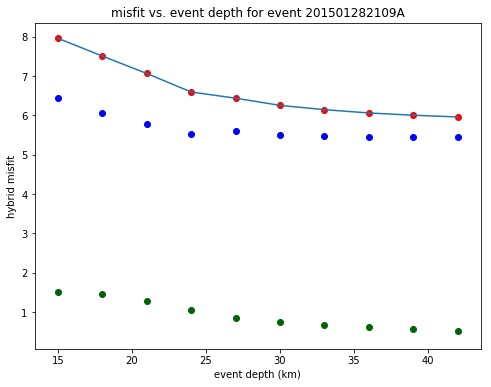

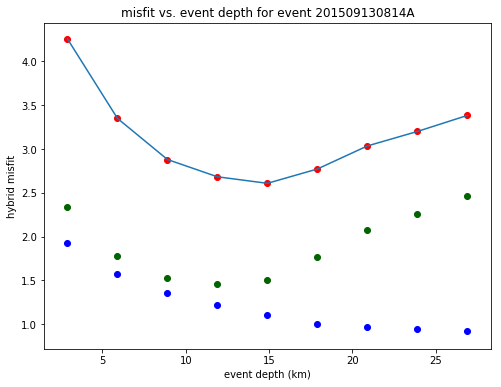

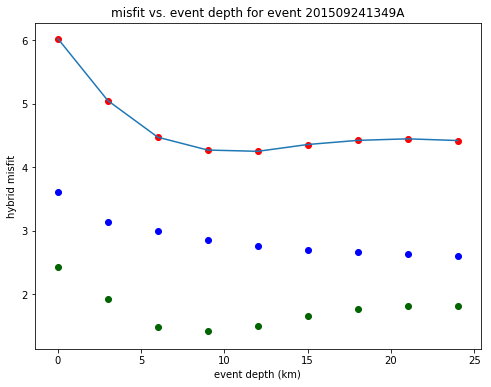

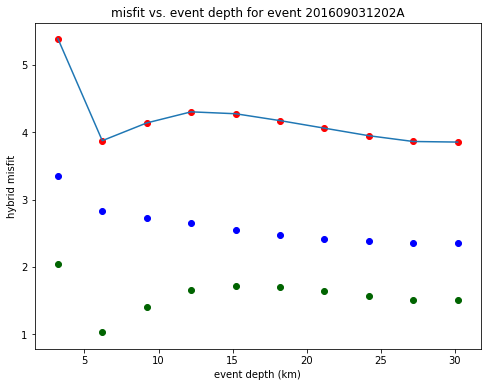

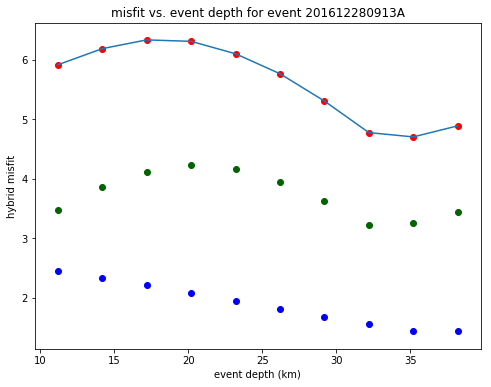

In [8]:
%store -r
event_list_file = "evtlst.txt"
print(os.path.abspath('.'))
#os.chdir('..')
print(Eca_all)
print(Esa_all)

for ievt in open(event_list_file,'r').readlines():
    evtnm = ievt.strip()
    Eca = Eca_all[evtnm]
    Esa = Esa_all[evtnm]
    Ecnorm = Eca / (np.amax(Eca)-np.amin(Eca))
    Esnorm = Esa / (np.amax(Esa)-np.amin(Esa))
    misfit = Ecnorm + Esnorm
    
    os.chdir("cmt3d_syn_"+evtnm)
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    pert_list = []
    for idir in cal_dirs:
        ipert = idir.strip().split("/")[2]
        pert_list.append(ipert.strip().split("_")[1])
    parlist = pert_list
    evdp,_,_,_,_,_,_,_,_ = read_cmt("CMTSOLUTION")
    depth = np.zeros((len(pert_list)))
    for i in range(0,len(pert_list)):
        pert_sign = pert_list[i].strip()[0]
        pert_val = pert_list[i].strip()[1:]
        if(pert_sign=='d'):
            depth[i] = evdp + int(pert_val)
        elif(pert_sign=='u'):
            depth[i] = evdp - int(pert_val)
        else:
            depth[i] = evdp
    result = dict(zip(depth,parlist))
    depth = sorted(result.keys())
    parlist = itemgetter(*depth)(result)
    depth = list(depth)
    parlist = list(parlist)
    print(depth)
    print(parlist)
    
    plt.figure(figsize=(8,6))
    plt.plot(depth,misfit)
    for i in range(0,len(misfit)):
        plt.scatter(depth[i],misfit[i],color='red')
        plt.scatter(depth[i],Ecnorm[i],color='blue')
        plt.scatter(depth[i],Esnorm[i],color='darkgreen')
    plt.title('misfit vs. event depth for event '+evtnm)
    plt.xlabel('event depth (km)')
    plt.ylabel('hybrid misfit')
    
    os.chdir('..')
    